In [1]:
%matplotlib inline
import blocks
import theano
import theano.tensor as T
import numpy as np

Using gpu device 0: GeForce GT 750M


In [2]:
from matplotlib.pyplot import *
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

In [3]:
import os
import h5py
import pyret.filtertools as ft
import pyret.stimulustools as st
import pyret.spiketools as spkt
import pyret.visualizations as viz

## Helper functions

In [4]:
def rolling_window(a, window):
    """
    Make an ndarray with a rolling window of the last dimension

    Parameters
    ----------
    a : array_like
        Array to add rolling window to
    window : int
        Size of rolling window

    Returns
    -------
    Array that is a view of the original array with a added dimension
    of size w.

    Examples
    --------
    >>> x=np.arange(10).reshape((2,5))
    >>> rolling_window(x, 3)
    array([[[0, 1, 2], [1, 2, 3], [2, 3, 4]],
           [[5, 6, 7], [6, 7, 8], [7, 8, 9]]])

    Calculate rolling mean of last dimension:

    >>> np.mean(rolling_window(x, 3), -1)
    array([[ 1.,  2.,  3.],
           [ 6.,  7.,  8.]])

    """
    assert window >= 1, "`window` must be at least 1."
    assert window < a.shape[-1], "`window` is too long."

    # # with strides
    shape = a.shape[:-1] + (a.shape[-1] - window, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

# Data loading - from HDF5

In [5]:
datadir = os.path.expanduser('~/experiments/data/012314b/')
filename = 'retina_012314b.hdf5'
f = h5py.File(os.path.join(datadir, filename))

IOError: Unable to create file (Unable to open file: name = '/users/lmcintosh/experiments/data/012314b/retina_012314b.hdf5', errno = 2, error message = 'no such file or directory', flags = 15, o_flags = a02)

In [62]:
stim = f['stimulus/sequence']
timestamps = f['stimulus/timestamps']
spk = f['spikes']

In [39]:
sta, tax = ft.getsta(np.array(timestamps), np.array(stim), np.array(spk['cell1']), 40)
viz.plotsta(tax,sta)

In [78]:
# bin spikes
bspk, tbins = spkt.binspikes(spk['cell1'], time=np.append(timestamps, timestamps[-1]+0.01))
bspk = bspk[40:]

In [ ]:
stim_rolled = rolling_window(np.array(stim), 40)
newstim = np.rollaxis(np.rollaxis(stim_rolled, 2, 0), 3, 1)

In [ ]:
X = newstim
y = bspk

# Data loading - from .mat

In [5]:
from scipy.io import loadmat
import os.path as path

data_dir = '/Users/lmcintosh/Git/deepRGC/datasets/white_noise/'
metadata = np.load(path.join(data_dir, 'metadata.npz'))['metadata'].item()
stim  = np.memmap(path.join(data_dir, 'stim_norm.dat'), dtype=metadata['stim_norm_dtype'], 
                  mode='r', shape=metadata['stim_norm_shape'])
rates = np.memmap(path.join(data_dir, 'rates.dat'), dtype=metadata['rates_dtype'], 
                  mode='r', shape=metadata['rates_shape'])

In [6]:
times = np.linspace(0, 0.01*rates.shape[0], rates.shape[0])

### Smooth raw spike count with 10 ms std Gaussian to get PSTHs

In [7]:
from lnl_model_functions import gaussian

In [8]:
rates_filt = np.zeros(rates.shape)
filt       = gaussian(x=np.linspace(-5,5,10), sigma=1, mu=0)
for cell in xrange(rates.shape[1]):
    rates_filt[:,cell] = np.convolve(rates[:,cell], filt, mode='same')

### Store rolled stimulus and filtered rates as X and y

In [9]:
stim_sliced = stim[34:-34, 34:-34,:]
#stim_sliced = stim[52:64, 36:48]
X = rolling_window(stim_sliced, 40)
X = np.rollaxis(X, 2)
X = np.rollaxis(X, 3, 1)

y = rates_filt[X.shape[1]:]

In [10]:
X.shape

(299850, 40, 32, 32)

In [11]:
y.shape

(299850, 11)

# Blocks

In [12]:
X.shape

(299850, 40, 32, 32)

In [13]:
from blocks.bricks.conv import Convolutional, ConvolutionalLayer, ConvolutionalActivation
from blocks.initialization import IsotropicGaussian, Constant

In [14]:
# convbrick = Convolutional((11,11), 1, 40, batch_size=16, image_size=(100,100), weights_init=IsotropicGaussian(), biases_init=Constant(0.01))
convbrick = Convolutional((11,11), 1, 40, batch_size=16, image_size=(32,32), weights_init=IsotropicGaussian(), biases_init=Constant(0.01))

In [15]:
convbrick.initialize()

In [16]:
x = T.ftensor4()

In [17]:
y = convbrick.apply(x)

In [18]:
f = theano.function(inputs=[x], outputs=[y])

In [19]:
output = f(X[:32,:,:,:])

In [20]:
output[0].shape

(32, 1, 22, 22)

### convolutional layer

In [167]:
from blocks.bricks import Rectifier

In [221]:
convlayer = ConvolutionalLayer(Rectifier().apply, filter_size=(11,11), num_filters=1, num_channels=40, batch_size=256, pooling_size=(10,10), image_size=(100,100), weights_init=IsotropicGaussian(), biases_init=Constant(0.01))

In [222]:
convlayer.initialize()

In [223]:
convlayer.apply(x)

convolutionallayer_apply_output

In [224]:
f = theano.function(inputs=[x], outputs=[convlayer.apply(x)])

In [225]:
output = f(newstim[:512,:,:,:])

In [226]:
output[0].shape

(512, 1, 9, 9)

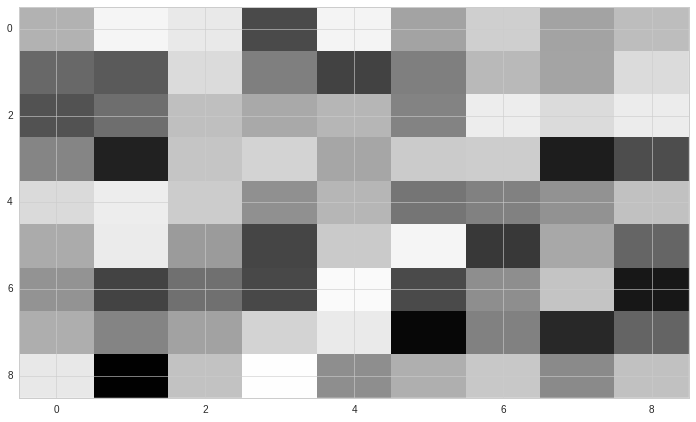

In [229]:
plt.imshow(np.squeeze(output[0][0,0,:,:]))